<a href="https://colab.research.google.com/github/stratoskar/Diploma_Thesis/blob/main/Notebooks/San_Fransisco_XGboost_RandomForest_LSTM_Enco-Deco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Phase 4: Build XGboost machine learning model for traffic flow forecast

In [1]:
# measure execution time
#%load_ext autotime

# disable warnings
import warnings
warnings.filterwarnings('ignore')

# standard library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

### Load the time series traffic flow dataset
In this step we are doing the following operations:
- Read the data
- Change the name of columns

In [3]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
time_series_file_path = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Data/time_series.txt'

In [9]:
# read dataset
time_series = pd.read_csv(time_series_file_path)

# this list contains the column names
columns = ["Taxi ID","Traj ID","Path","Length"]

# generate the columns of the dataset
i =4
while(True):
    if i == 4:
        columns.append(pd.to_datetime('2008-05-18 00:00:00'))
    else:
        columns.append(columns[i-1] + timedelta(seconds=1800))

    if (columns[i]>=pd.to_datetime('2008-05-24 23:59:59.000130')):
        break

    i+=1

# delete the last timestamp
columns.pop()

# assign new column names to our dataframe
time_series.columns = columns

### Transform the time series dataset
In this step we are doing the following operations:
- Reshape it to long format using melt function
- Encode categorical values
- Preprocess the data types of each column

In [10]:
# reshape the data from wide format to long format
id_cols = ['Taxi ID','Traj ID', 'Path', 'Length']
time_cols = time_series.iloc[:,2:].columns
time_series = time_series.melt(id_vars=id_cols, value_vars=time_cols, var_name='Time Column', value_name='Traffic Flow')
time_series['Time Column'] = pd.to_datetime(time_series['Time Column'])

# sort rows by Path and Time
time_series.sort_values(by=['Path','Time Column'],inplace=True)

In [11]:
# convert path column from categorical to numerical
from sklearn.preprocessing import LabelEncoder

# create an instance of LabelEncoder
label_encoder = LabelEncoder()

# fit label encoder on the 'Path' column
time_series['Path'] = label_encoder.fit_transform(time_series['Path'])

# sort the data based in Path column
time_series = time_series.sort_values(by=['Path','Time Column'])

# print data
time_series.head()

,Taxi ID,Traj ID,Path,Length,Time Column,Traffic Flow
593,97,297,0,8,2008-05-18 00:00:00,4
1593,97,297,0,8,2008-05-18 00:30:00,4
2593,97,297,0,8,2008-05-18 01:00:00,4
3593,97,297,0,8,2008-05-18 01:30:00,2
4593,97,297,0,8,2008-05-18 02:00:00,9


### Weather data
In the weather dataset of San Francisco area, there are many columns that are useless for our research. We just drop them and preprocess the dataset.

In this step we are doing the following operations:
- Read the weather data
- Drop uneccessary informatio n
- Encode categorical attributes
- Fill Nan values

In [12]:
file_path_weather_data = '/content/drive/MyDrive/Colab Notebooks/San Francisco TF Pred/Data/weather_data.csv'

In [14]:
# read weather data
weather_data = pd.read_csv(file_path_weather_data,sep=',')

# drop unecessary columns.
# dropped columns can either have NaN values, or not be associated with traffic flow.
# columns kept: temperature, humidity, windspeed, sealevelpressure, visibility
weather_data = weather_data.drop(['name','feelslike','dew','precip','precipprob','preciptype',
                                  'snow','snowdepth','windgust','winddir','cloudcover',
                                  'solarradiation','solarenergy','uvindex','severerisk','stations','icon'],axis=1)

There is one column that contains categorical vales. Use one-hot encoding to represent them as numerical vectors.

In [15]:
# view the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            142
Rain, Overcast        1
Name: conditions, dtype: int64

In [16]:
# change the only 'Rain, Overcast' value to 'Overcast'
weather_data.loc[weather_data['conditions'] == 'Rain, Overcast', 'conditions'] = 'Overcast'

In [17]:
# view again the values of "conditions" column
weather_data['conditions'].value_counts()

Partially cloudy    435
Clear               166
Overcast            143
Name: conditions, dtype: int64

In [18]:
# one-hot encode the  "conditions" column
conditions = pd.get_dummies(weather_data['conditions'], prefix='conditions')
weather_data.drop('conditions',axis=1,inplace=True)

# concatenate the one-hot encoded columns to the original DataFrame
weather_data = pd.concat([weather_data, conditions], axis=1)

Now, there are not categorical values.

In [20]:
# view for null values
weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744 entries, 0 to 743
Data columns (total 9 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   datetime                     744 non-null    object 
 1   temp                         744 non-null    float64
 2   humidity                     744 non-null    float64
 3   windspeed                    744 non-null    float64
 4   sealevelpressure             744 non-null    float64
 5   visibility                   744 non-null    float64
 6   conditions_Clear             744 non-null    uint8  
 7   conditions_Overcast          744 non-null    uint8  
 8   conditions_Partially cloudy  744 non-null    uint8  
dtypes: float64(5), object(1), uint8(3)
memory usage: 37.2+ KB


There are not null values in the weather dataset too!

In [21]:
# covnert datetime column to appropriate format
weather_data['datetime'] = pd.to_datetime(weather_data['datetime'])

# drop rows that are not in within the interval [2008-05-18,2008-05-24]
start_date = pd.to_datetime('2008-05-18')
end_date = pd.to_datetime('2008-05-25')

weather_data = weather_data[(weather_data['datetime'] >= start_date) & (weather_data['datetime'] <= end_date)].reset_index(drop=True)

### Connect the two dataframes to one
Use time information to correctly connect the weather data and traffic flow data together.

In [22]:
# connect two dataframes, time-series traffic flow and weather data
time_series.set_index('Time Column', inplace=True)
weather_data.set_index('datetime', inplace=True)

# resample the 'weather_data' dataset to 30-minute intervals and forward-fill the missing values
weather_data = weather_data.resample('30T').ffill()

# merge the time_series and weather_data_resampled datasets based on their indexes
time_series_weather = time_series.merge(weather_data, left_index=True, right_index=True)

### Feature Creation From Time Information
In this step we define some features based on time series timestamps.
- Day, dayfweek, hour and minute features derive directly from the timestamp column of the dataset.
- Hour_sin and Hour_cos columns transform the hour values into a cyclic representation, where the values range from -1 to 1. This transformation is used in time series analysis to capture the periodic patterns or cyclical nature of time-related data.
- Use also the 3_hour_interval to describe, in which interval of the day data refer to.

In [23]:
time_series_weather = time_series_weather.reset_index()
time_series_weather.rename(columns={'index': 'Time Column'}, inplace=True)

In [24]:
### extract timestamp information to different columns ###

time_series_weather['hour'] = time_series_weather['Time Column'].dt.hour
time_series_weather['dayofweek'] = time_series_weather['Time Column'].dt.dayofweek
time_series_weather['day'] = time_series_weather['Time Column'].dt.day
time_series_weather['minute'] = time_series_weather['Time Column'].dt.minute

### circular Encoding for cyclic time features ###

time_series_weather['hour_sin'] = np.sin(2 * np.pi * time_series_weather['hour'] / 24)
time_series_weather['hour_cos'] = np.cos(2 * np.pi * time_series_weather['hour'] / 24)

time_series_weather['day_of_week_sin'] = np.sin(2 * np.pi * time_series_weather['dayofweek'] / 7)
time_series_weather['day_of_week_cos'] = np.cos(2 * np.pi * time_series_weather['dayofweek'] / 7)

time_series_weather['day_sin'] = np.sin(2 * np.pi * time_series_weather['day'] / 31)
time_series_weather['day_cos'] = np.cos(2 * np.pi * time_series_weather['day'] / 31)

time_series_weather['minute_sin'] = np.sin(2 * np.pi * time_series_weather['minute'] / 60)
time_series_weather['minute_cos'] = np.cos(2 * np.pi * time_series_weather['minute'] / 60)

In [25]:
# define a custom function to determine the three-hour interval, based in timestamp hour information
def get_3hour_interval(hour):
    if hour in [0, 1, 2]:
        return 1
    elif hour in [3, 4, 5]:
        return 2
    elif hour in [6, 7, 8]:
        return 3
    elif hour in [9, 10, 11]:
        return 4
    elif hour in [12, 13, 14]:
        return 5
    elif hour in [15, 16, 17]:
        return 6
    elif hour in [18, 19, 20]:
        return 7
    elif hour in [21, 22, 23]:
        return 8
    else:
        return None

In [26]:
# apply the custom function on the data to create the '3hour_interval' column
time_series_weather['3hour_interval'] = time_series_weather['hour'].apply(get_3hour_interval)

In [27]:
# print dataset
time_series_weather

,Time Column,Taxi ID,Traj ID,Path,Length,Traffic Flow,temp,humidity,windspeed,sealevelpressure,...,minute,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,minute_sin,minute_cos,3hour_interval
0,2008-05-18 00:00:00,97,297,0,8,4,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
1,2008-05-18 00:00:00,2,83,1,3,4,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
2,2008-05-18 00:00:00,247,370,2,10,7,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
3,2008-05-18 00:00:00,327,78,3,2,5,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
4,2008-05-18 00:00:00,363,56,4,11,0,12.4,87.29,16.1,1017.7,...,0,0.000000,1.000000,-0.781831,0.623490,-0.485302,-0.874347,0.000000e+00,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335995,2008-05-24 23:30:00,403,113,995,6,2,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335996,2008-05-24 23:30:00,477,44,996,9,0,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335997,2008-05-24 23:30:00,135,125,997,2,3,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8
335998,2008-05-24 23:30:00,192,164,998,12,0,12.4,72.31,10.5,1015.0,...,30,-0.258819,0.965926,-0.974928,-0.222521,-0.988468,0.151428,5.665539e-16,-1.0,8


### Make Visualizations

In this step, we are doing the following operations:
- View total traffic flow (sum of traffic flow of every path in the dataset) per day. In this way we understand patterns that traffic flow has.

- View total traffic flow per day and 3-hour interval of the same day, to understand in which time of each day Traffic Flow is on peak.

In [30]:
import seaborn as sns

#### Visualise the Traffic Flow in every path of the dataset per day
Use the sum of traffic flow of every path at each timestep to generate a total overview about the data

In [31]:
# group by timestamp (index) and calculate the sum of the traffic flow
grouped_df = time_series_weather['Traffic Flow'].groupby(time_series_weather['Time Column']).sum()

# add results to dataframe
grouped_df = pd.DataFrame(grouped_df,index=grouped_df.index)

In [32]:
# add additional time information in the dataset
grouped_df['hour'] = grouped_df.index.hour
grouped_df['3hour_interval'] = grouped_df['hour'].apply(get_3hour_interval)
grouped_df['dayofweek'] = grouped_df.index.dayofweek

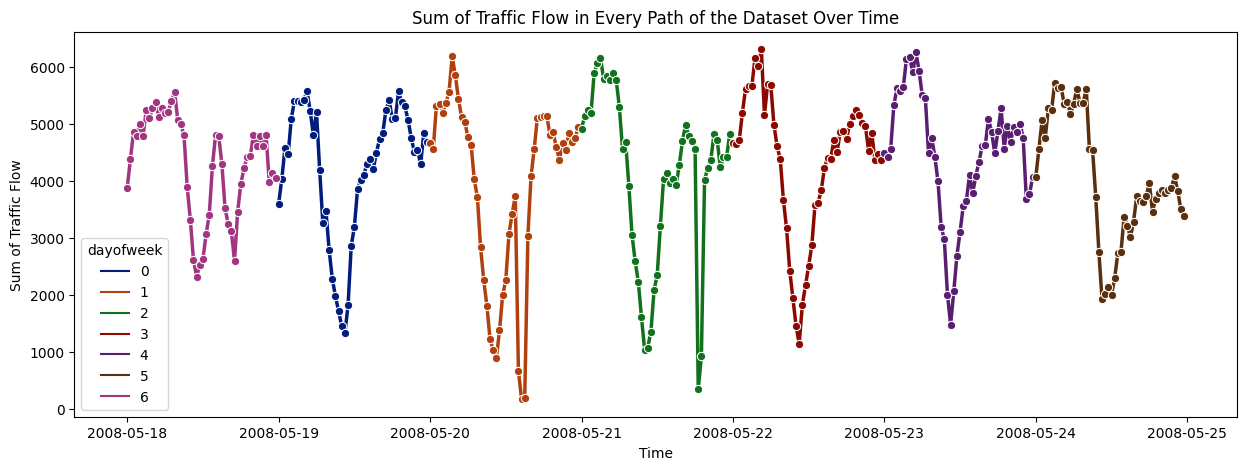

In [33]:
# create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# create a plot to view the results
plt.figure(figsize=(15,5))
sns.lineplot(grouped_df,x=grouped_df.index,y='Traffic Flow',hue='dayofweek',marker='o', palette=dark_palette,linewidth=2.5)
plt.xlabel('Time')
plt.ylabel('Sum of Traffic Flow')
plt.title('Sum of Traffic Flow in Every Path of the Dataset Over Time')
plt.show()

Based on graph above, we see that for each day, there is a seasonality pattern. In the noon hours Traffic Flow is lower than in the mornnings or in the evenings.

#### Visualize traffic flow per day and per 3hour time inteval

Text(0.5, 0, 'Time information every 30 minutes')

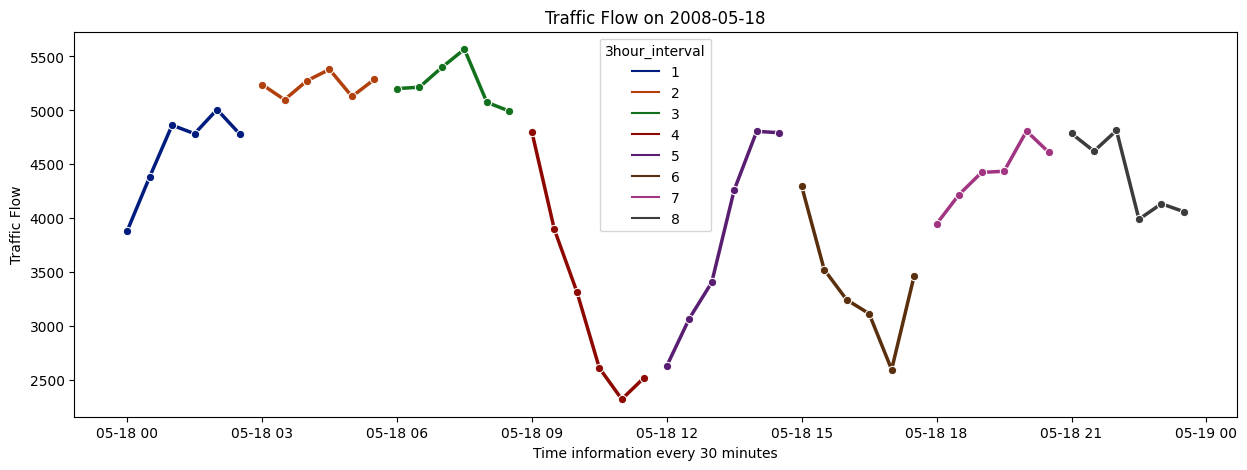

In [34]:
# traffic flow on 2008-05-18
pl = grouped_df[(grouped_df.index >= '2008-05-18 00:00:00') & (grouped_df.index < '2008-05-19 00:00:00')]

# Create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-18")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

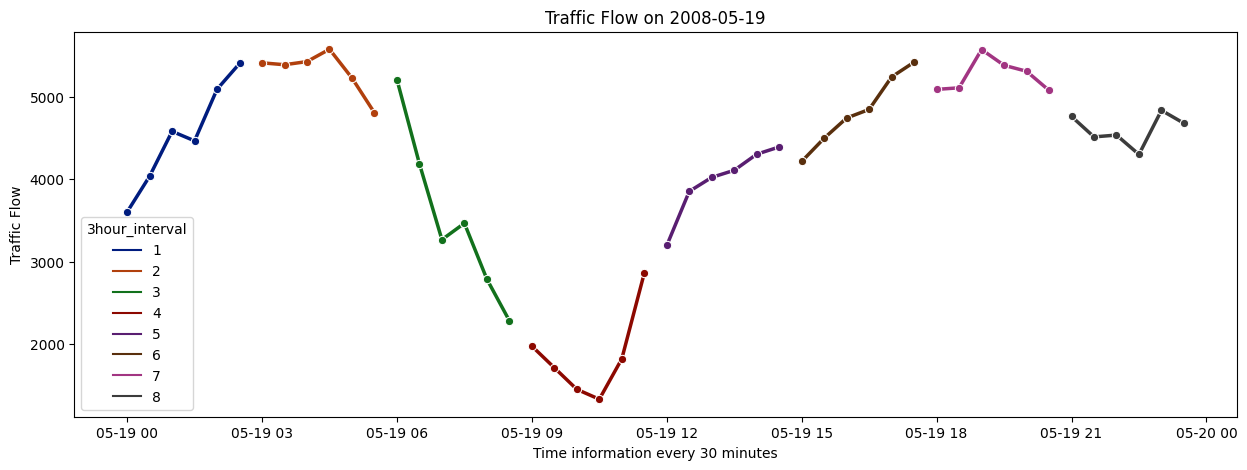

In [35]:
# traffic flow on 2008-05-19
pl = grouped_df[(grouped_df.index >= '2008-05-19 00:00:00') & (grouped_df.index < '2008-05-20 00:00:00')]

# Create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-19")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

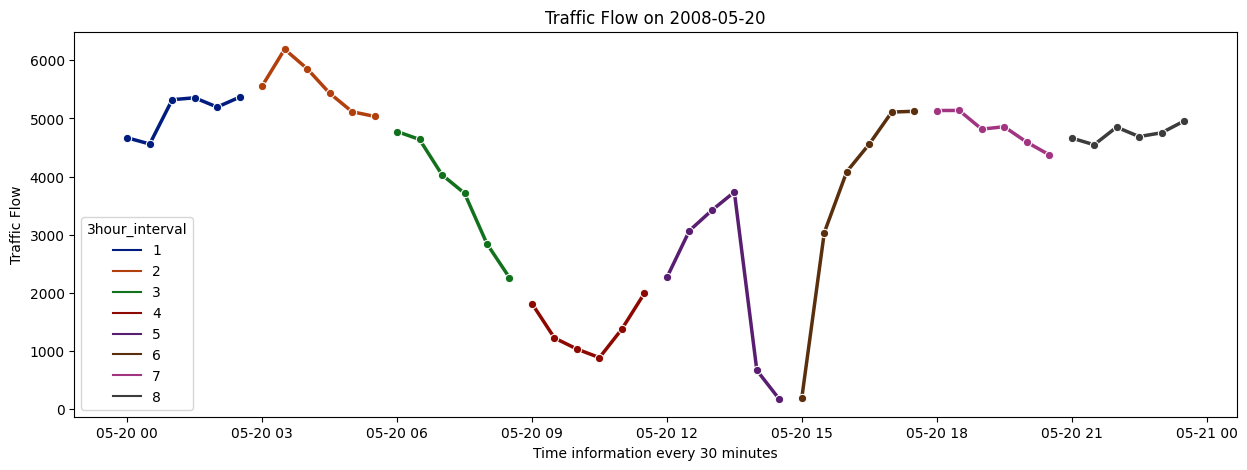

In [36]:
# traffic flow on 2008-05-20
pl = grouped_df[(grouped_df.index >= '2008-05-20 00:00:00') & (grouped_df.index < '2008-05-21 00:00:00')]

# Create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-20")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

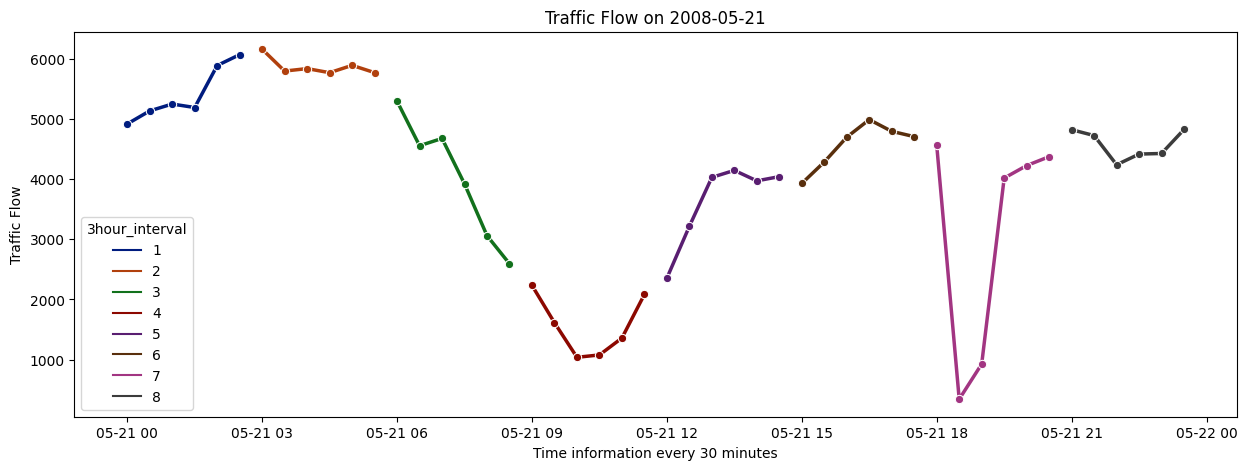

In [37]:
# traffic flow on 2008-05-21
pl = grouped_df[(grouped_df.index >= '2008-05-21 00:00:00') & (grouped_df.index < '2008-05-22 00:00:00')]

# Create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-21")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

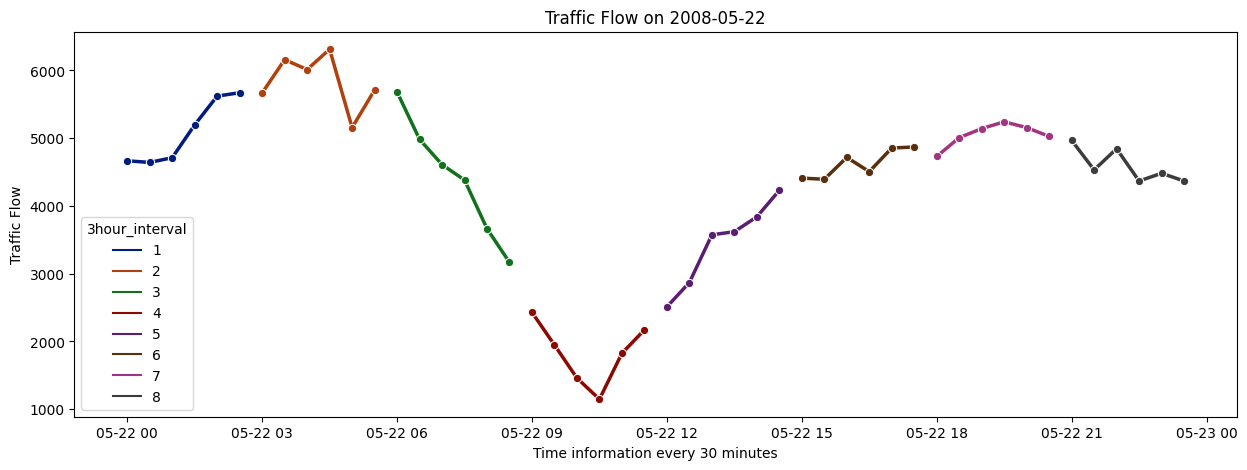

In [38]:
# traffic flow on 2008-05-22
pl = grouped_df[(grouped_df.index >= '2008-05-22 00:00:00') & (grouped_df.index < '2008-05-23 00:00:00')]

# Create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-22")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

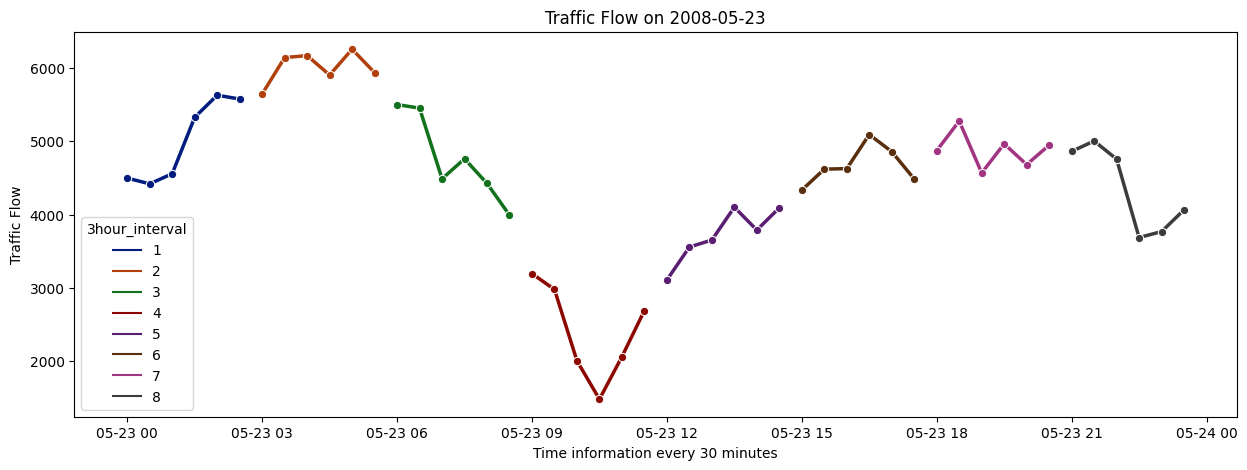

In [39]:
# traffic flow on 2008-05-23
pl = grouped_df[(grouped_df.index >= '2008-05-23 00:00:00') & (grouped_df.index < '2008-05-24 00:00:00')]

# Create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-23")
plt.xlabel("Time information every 30 minutes")

Text(0.5, 0, 'Time information every 30 minutes')

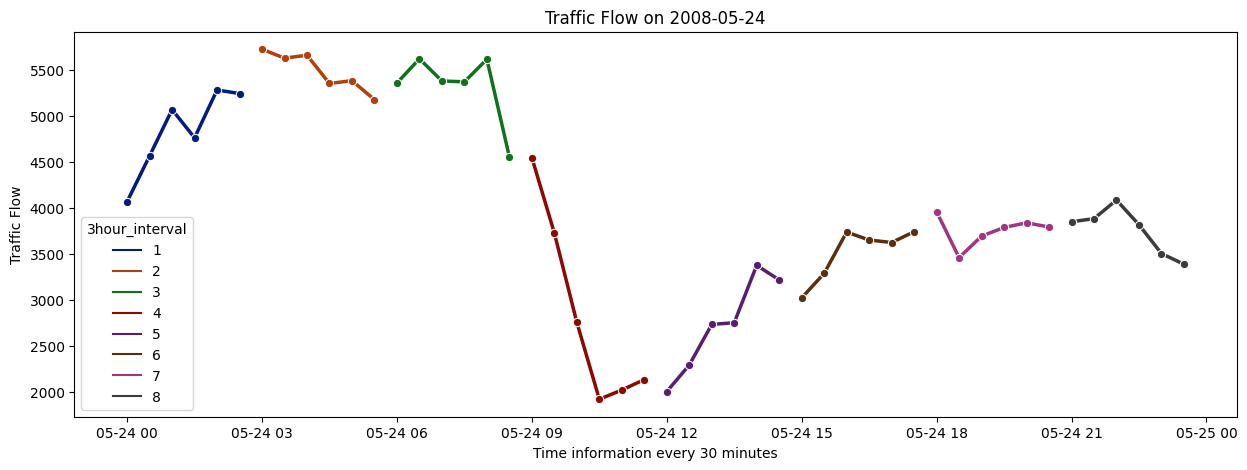

In [40]:
# traffic flow on 2008-05-24
pl = grouped_df[(grouped_df.index >= '2008-05-24 00:00:00') & (grouped_df.index < '2008-05-25 00:00:00')]

# Create a custom dark color palette
dark_palette = sns.color_palette('dark', n_colors=8)

# plot the data
plt.figure(figsize=(15,5))
sns.lineplot(pl,x='Time Column',y='Traffic Flow',hue='3hour_interval',marker='o', palette=dark_palette,linewidth=2.5)
plt.title("Traffic Flow on 2008-05-24")
plt.xlabel("Time information every 30 minutes")

#### Find highly correlated data in the dataset

<Axes: >

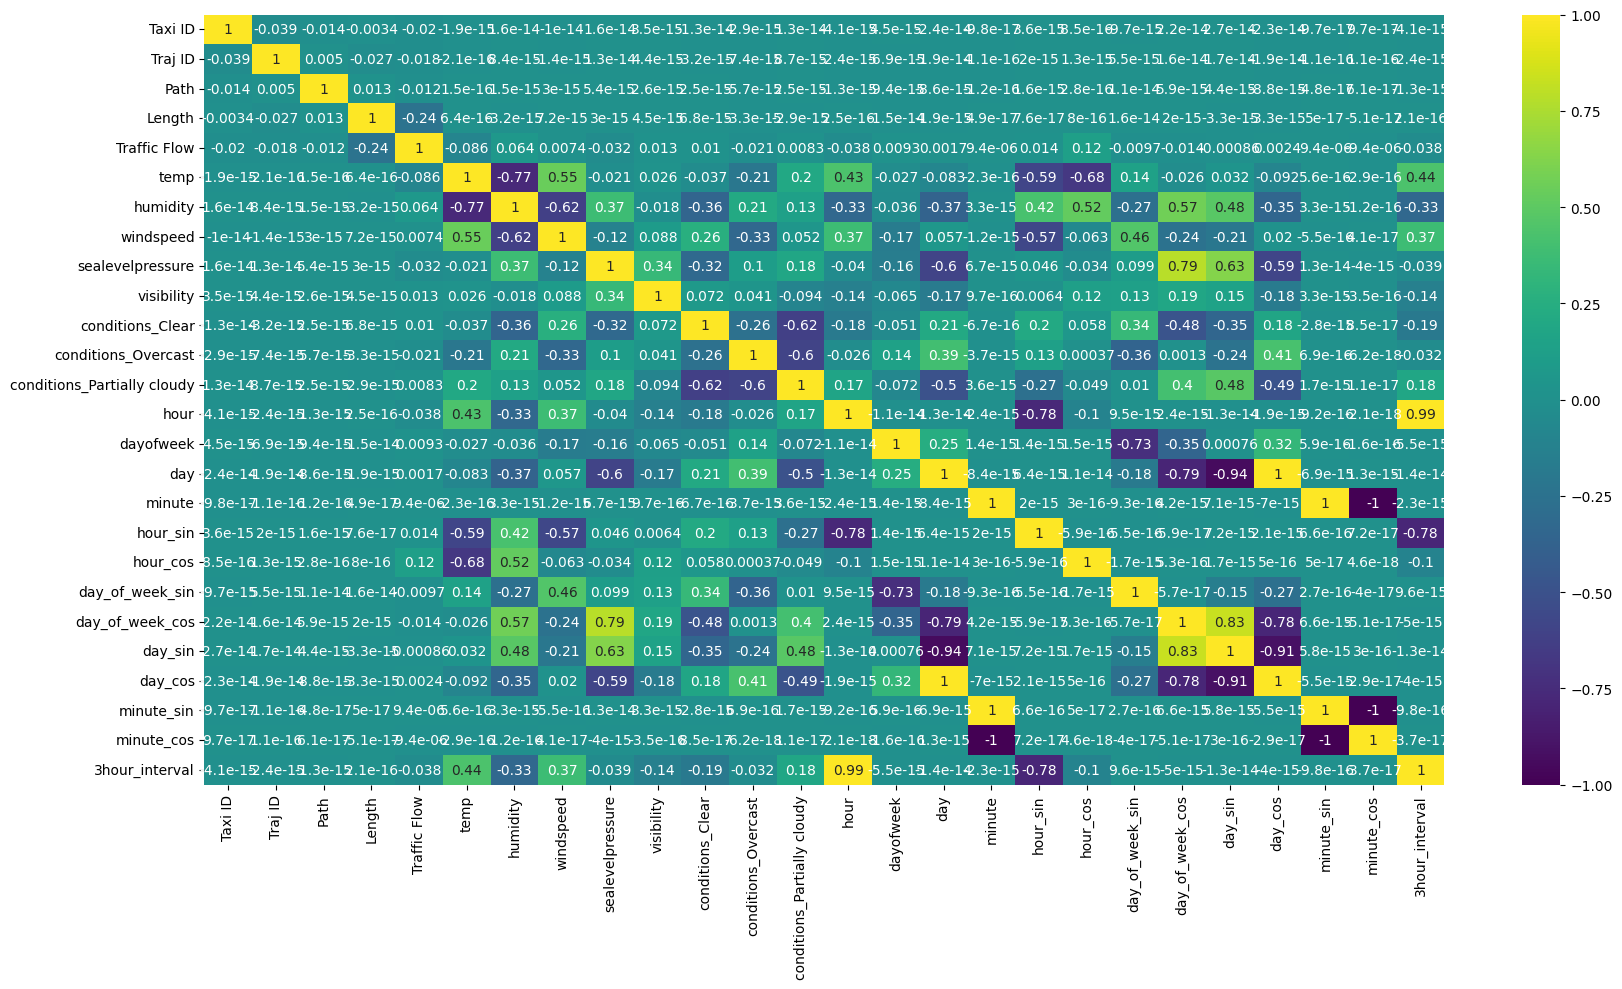

In [41]:
plt.figure(figsize=(20,10))
sns.heatmap(time_series_weather.corr(), annot=True, cmap='viridis')

Based on the above heatmap, we see that there are some features that are highly correlated. For example,
temperature is correlated wiith humidity, windspeed, the hour of day, 3hour_interval and circular encoding of hour feature. Based on this heatmap above, we can choose the features that will be used in the final model.

### Train - Test split
In this step, we split the data into two datasets train and test.
The time inteval of all observations in this dataset are within [18-05-2008, 24-05-2008].
- Train dataset contains all the data for each path till 2008-05-23 inclusive.
- The rest of the data (the most resent ones) are in the test dataset

In [42]:
# sort the time series data
time_series_weather.sort_values(by=['Path','Time Column'], inplace=True)

In [43]:
# define train data
train = time_series_weather.loc[time_series_weather['Time Column'] < '2008-05-24']

# define test data
test = time_series_weather.loc[time_series_weather['Time Column'] >= '2008-05-24']

# print the results
print("Train set shape: ",train.shape)
print("Test set shape: ",test.shape)

Train set shape:  (288000, 27)
Test set shape:  (48000, 27)


In [44]:
# redefine train and test sets based on correlated features (drop highly correlated features)
train = train.drop(['Time Column','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1)
test = test.drop(['Time Column','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1)

### Find the best lookback timesteps for our XGBoost model
In this step, we define the optimum lookback timestep number for our sliding window. This optimum number will be used by the model for forecasting. Also, since XGBoost is the best model based in RMSE score, we perform this operation only for this model.

#### Step 0: Create empty dataframe to store the scores per lookback timesteps

In [45]:
# find best lookback timesteps to perform analysis. Save those scores in a separate dataframe
lookback_scores = pd.DataFrame(columns=['#Timesteps','XGBoost Score'])
lookback_scores['#Timesteps'] = 0
lookback_scores['XGBoost Score'] = 0

#### Step 1: Create function that converts the data into a supervised problem
Consider for each path n_in timesteps of traffic flow in the past, in order to predict the n_out traffic flow timesteps in the future.

In [46]:
from pandas import DataFrame
from pandas import concat

# create functio for generating (X, y) pairs
def series_to_supervised(data, n_in=1, n_out=1):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('Traffic Flow %d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Traffic Flow %d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('Traffic Flow %d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    return agg

In [47]:
"""
Convert the training data into a supervised dataset. Create X,y pairs of the traffic column information.
Then, concatenate the rest of the culumns.
"""
def generate_X_y_pairs(data,n_in=1,n_out=1):
    new_data = pd.DataFrame()
    for item in data['Path'].unique():

        # call function only for traffic flow columns
        supervised_traffic_flow = series_to_supervised(pd.DataFrame(data[data['Path'] == item]['Traffic Flow']), n_in, n_out)

        # the rest of the columns are concatenated as they were
        supervised_traffic_flow = pd.concat([supervised_traffic_flow, time_series_weather[time_series_weather['Path'] == item]], axis=1)

        new_data = pd.concat([new_data,supervised_traffic_flow])

    new_data.dropna(inplace=True)
    return new_data

#### Step 2: Create a loop. In each loop, we are doing the following:
- 0. Convert train and test sets into supervised problem with lookback timesteps.
- 1. Define features and labels.
- 2. Train the XGboost model with defult parameters
- 3. Predict on the test set
- 4. Save RMSE in a dataframe

In [48]:
# import libraries
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [49]:
for lookback in [2,3,4,5,6]: # different lookback sizes

    # convert train and test data to supervised
    train_s = generate_X_y_pairs(train,lookback)
    test_s = generate_X_y_pairs(test,lookback)

    print("Lookback = "+str(lookback)+" - To supervised: Completed!")

    # add rolling mean information
    train_s['rolling_mean'] = 0
    test_s['rolling_mean'] = 0

    train_s['rolling_mean'] = train_s.iloc[:,0:lookback].mean(axis=1)
    test_s['rolling_mean'] = test_s.iloc[:,0:lookback].mean(axis=1)

    # define features
    features_s = train_s.drop(['Time Column','Traffic Flow','Traffic Flow 1(t)'],axis=1).columns

    # define label
    labels_s = ['Traffic Flow 1(t)']

    # create X_train and y_train datasets
    X_train_s = train_s[features_s]
    y_train_s = train_s[labels_s]

    # create X_test and y_test datasets
    X_test_s = test_s[features_s]
    y_test_s = test_s[labels_s]

    print("Lookback = "+str(lookback)+" - Train and Test sets: Completed!")

    # define XGBoost regression model
    reg = xgb.XGBRegressor(objective='reg:squarederror',n_estimators=1000,early_stopping_rounds = 5)

    # train the XGBoost model with feature weights, use validation set on test data)
    reg.fit(X_train_s, y_train_s, eval_set=[(X_train_s, y_train_s), (X_test_s,y_test_s)],verbose=False)

    print("Lookback = "+str(lookback)+" - Trainning: Completed!")

    # make predictions
    y_pred_s = reg.predict(X_test_s)

    # calculate RMSE score
    rmse = mean_squared_error(y_test_s, y_pred_s, squared=False)

    # create a new row as a dictionary
    new_row = {'#Timesteps': lookback, 'XGBoost Score': rmse}

    # append the new row to the DataFrame
    lookback_scores = lookback_scores.append(new_row, ignore_index=True)

    print("Lookback = "+str(lookback)+" - Saved Results: Completed!")

Lookback = 2 - To supervised: Completed!
Lookback = 2 - Train and Test sets: Completed!
Lookback = 2 - Trainning: Completed!
Lookback = 2 - Saved Results: Completed!
Lookback = 3 - To supervised: Completed!
Lookback = 3 - Train and Test sets: Completed!
Lookback = 3 - Trainning: Completed!
Lookback = 3 - Saved Results: Completed!
Lookback = 4 - To supervised: Completed!
Lookback = 4 - Train and Test sets: Completed!
Lookback = 4 - Trainning: Completed!
Lookback = 4 - Saved Results: Completed!
Lookback = 5 - To supervised: Completed!
Lookback = 5 - Train and Test sets: Completed!
Lookback = 5 - Trainning: Completed!
Lookback = 5 - Saved Results: Completed!
Lookback = 6 - To supervised: Completed!
Lookback = 6 - Train and Test sets: Completed!
Lookback = 6 - Trainning: Completed!
Lookback = 6 - Saved Results: Completed!


####  Step 3: Print RMSE scores over lookback timesteps into a graph

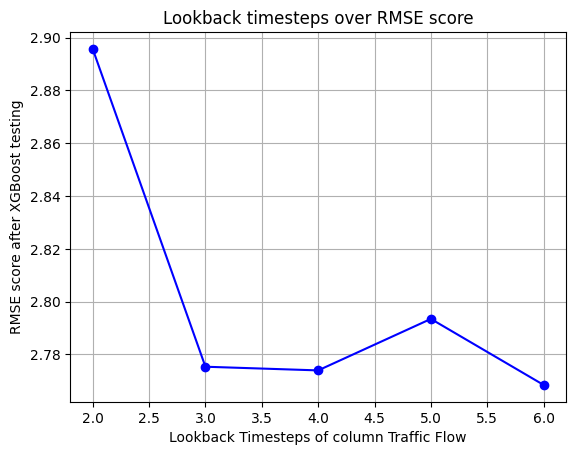

In [50]:
# plot the data
plt.plot(lookback_scores['#Timesteps'], lookback_scores['XGBoost Score'], linestyle='-', marker='o', color='b')

# set plot title and axis labels
plt.title('Lookback timesteps over RMSE score')
plt.xlabel('Lookback Timesteps of column Traffic Flow')
plt.ylabel('RMSE score after XGBoost testing')

# add gridlines
plt.grid(True)

# show the plot
plt.show()

In [51]:
# find the timesteps corresponding to the minimum RMSE score
optimum_lookback = int(lookback_scores['#Timesteps'].loc[lookback_scores['XGBoost Score'].idxmin()])

### Perform Grid Search CV to find the optimum parameters for the XGBoost model
This step is essential to tune correctly the XGboost model.

#### Step 0: Split train and test into supervised problem, based on optimum lookback timesteps that found above.

In [52]:
# convert train and test data to supervised problem based in the optimum lookback step we defined above.
train = generate_X_y_pairs(train,optimum_lookback)
test = generate_X_y_pairs(test,optimum_lookback)

#### Step 1: Extract features about trend of time series
In this step we define the rolling mean and rolling variance of a window. Since we are trying to forecast the last value of each window, only the first optimum_lookback values in the window are used to compute rolling features. The last value (that we are trying to forecast) is not included.

In [53]:
# add rolling mean information
train['rolling_mean'] = 0
test['rolling_mean'] = 0

train['rolling_var'] = 0
test['rolling_var'] = 0

# calculate rolling mean of window
train['rolling_mean'] = train.iloc[:,0:optimum_lookback].mean(axis=1)
test['rolling_mean'] = test.iloc[:,0:optimum_lookback].mean(axis=1)

# calculate rolling variance of window
train['rolling_var'] = train.iloc[:, 0:optimum_lookback].var(axis=1)
test['rolling_var'] = test.iloc[:, 0:optimum_lookback].var(axis=1)

####  Step 2: Define labels and features
- Features will help the XGboost algorithm to predict the output value, the label. We will use all the traffic flow information at previous timesteps (t-n,t-n+1...,t-2,t-1), as well as the rest of the features (time and trend information) as features.
- Label will be out target value, the Traffic Flow at timestep t.

In [54]:
# define features
features = train.drop(['Time Column','Traffic Flow 1(t)','Traffic Flow','hour', 'hour_sin','day_of_week_cos', 'dayofweek', 'day', 'minute'],axis=1).columns

# define labels
labels = ['Traffic Flow 1(t)']

# create X_train and y_train data sets
X_train = train[features]
y_train = train[labels]

# create X_test and y_test data sets
X_test = test[features]
y_test = test[labels]

In [55]:
# show shape information about X and y training and testing sets
print("Shape of X_train is: ",X_train.shape)
print("Shape of y_train is: ",y_train.shape)
print("Shape of X_test is: ",X_test.shape)
print("Shape of y_test is: ",y_test.shape)

Shape of X_train is:  (282000, 27)
Shape of y_train is:  (282000, 1)
Shape of X_test is:  (42000, 27)
Shape of y_test is:  (42000, 1)


#### Step 3: Apply GridSearchCV
Use a 5-fold K-fold cross-validation was used for learning the optimum hyperparameters for the XGBoost algorithm.

In [56]:
from sklearn.model_selection import GridSearchCV

In [58]:
# tune hyperparameters using XGboost
xgb_params = {
    "n_estimators": [500],
    "learning_rate": [0.1],
    "max_depth": [3,5,9],
    "objective":['reg:squarederror'],
    "gamma": [0,1,2],
    "alpha": [0,0.1,1,2]
}

# define GridSearchCV object
xgb_grid = GridSearchCV(xgb.XGBRegressor(),
                        xgb_params,cv=3,
                        verbose=1,
                        scoring= "neg_mean_squared_error")

# train on train data using 5 fold CV
xgb_grid.fit(X_train,y_train,
             early_stopping_rounds=5,
             eval_set=[(X_train, y_train), (X_test,y_test)],
             eval_metric='rmse')

# print the best hyperparameters and corresponding score
print("Best Hyperparameters: ", xgb_grid.best_params_)
print("Best Score: ", xgb_grid.best_score_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[0]	validation_0-rmse:6.83366	validation_1-rmse:6.03858
[1]	validation_0-rmse:6.32162	validation_1-rmse:5.57675
[2]	validation_0-rmse:5.86972	validation_1-rmse:5.16866
[3]	validation_0-rmse:5.47044	validation_1-rmse:4.81207
[4]	validation_0-rmse:5.12391	validation_1-rmse:4.50004
[5]	validation_0-rmse:4.81904	validation_1-rmse:4.23127
[6]	validation_0-rmse:4.55769	validation_1-rmse:3.99869
[7]	validation_0-rmse:4.33057	validation_1-rmse:3.80203
[8]	validation_0-rmse:4.13603	validation_1-rmse:3.63108
[9]	validation_0-rmse:3.96743	validation_1-rmse:3.48778
[10]	validation_0-rmse:3.82465	validation_1-rmse:3.36536
[11]	validation_0-rmse:3.70289	validation_1-rmse:3.26414
[12]	validation_0-rmse:3.59927	validation_1-rmse:3.18017
[13]	validation_0-rmse:3.51201	validation_1-rmse:3.11118
[14]	validation_0-rmse:3.43693	validation_1-rmse:3.05331
[15]	validation_0-rmse:3.37453	validation_1-rmse:3.00628
[16]	validation_0-rmse:3.32008	valid

KeyboardInterrupt: ignored

### Create dataframe to save actual values and model predictions

In [59]:
total_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
total_predictions['Actual'] = y_test['Traffic Flow 1(t)'].values
total_predictions['Path'] = X_test['Path'].values

### Train an XGboost model
We will fit all the data in this model using the optimum parameters we found above. The optimum parameters for this dataset are:
- n_estimators = 500
- learning_rate = 0.1
- max_depth = 9
- alpha = 0.1
- gamma = 1

#### Step 0: Create XGBoost model and train it

In [60]:
# define XGBoost regressor, use also gamma and alpha values for regularization
reg = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=500,
    early_stopping_rounds=5,
    max_depth=9 ,
    learning_rate=0.1,
    gamma=1,
    alpha=0.1
)

# train the XGBoost model with feature weights, use validation set on test data)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test,y_test)],
        verbose=True)

[0]	validation_0-rmse:6.79499	validation_1-rmse:6.03665
[1]	validation_0-rmse:6.24633	validation_1-rmse:5.56741
[2]	validation_0-rmse:5.75995	validation_1-rmse:5.15244
[3]	validation_0-rmse:5.33265	validation_1-rmse:4.79089
[4]	validation_0-rmse:4.95472	validation_1-rmse:4.48448
[5]	validation_0-rmse:4.62409	validation_1-rmse:4.21535
[6]	validation_0-rmse:4.33621	validation_1-rmse:3.98854
[7]	validation_0-rmse:4.08553	validation_1-rmse:3.78994
[8]	validation_0-rmse:3.86806	validation_1-rmse:3.62417
[9]	validation_0-rmse:3.68079	validation_1-rmse:3.47681
[10]	validation_0-rmse:3.51872	validation_1-rmse:3.35609
[11]	validation_0-rmse:3.37808	validation_1-rmse:3.25844
[12]	validation_0-rmse:3.25847	validation_1-rmse:3.17644
[13]	validation_0-rmse:3.15599	validation_1-rmse:3.11255
[14]	validation_0-rmse:3.06984	validation_1-rmse:3.05490
[15]	validation_0-rmse:2.99444	validation_1-rmse:3.00277
[16]	validation_0-rmse:2.92978	validation_1-rmse:2.96386
[17]	validation_0-rmse:2.87587	validation

XGBRegressor(alpha=0.1, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=5,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, ...)

##### Feature Importance of XGBoost model
Show how our model used the feautres, in order to perform splits.

<Figure size 1500x500 with 0 Axes>

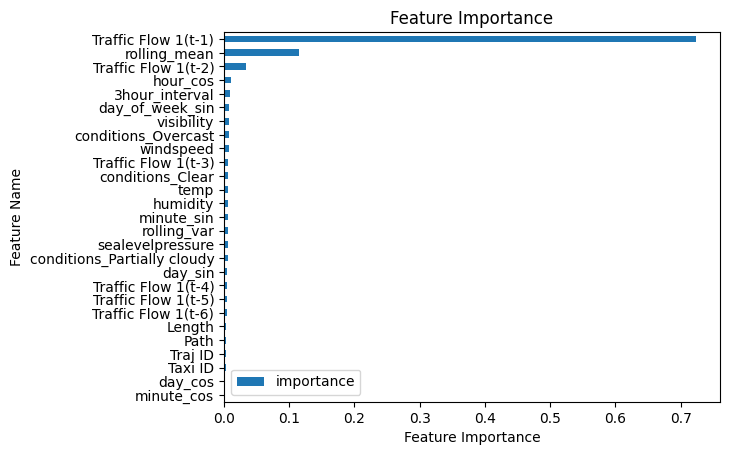

In [61]:
# Show how much each of the features was used in our regression analysis
plt.figure(figsize=(15,5))
fi = pd.DataFrame(data=reg.feature_importances_,index=reg.feature_names_in_,columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.show()

##### Plot train and validation errors of XGBoost model in the same graph

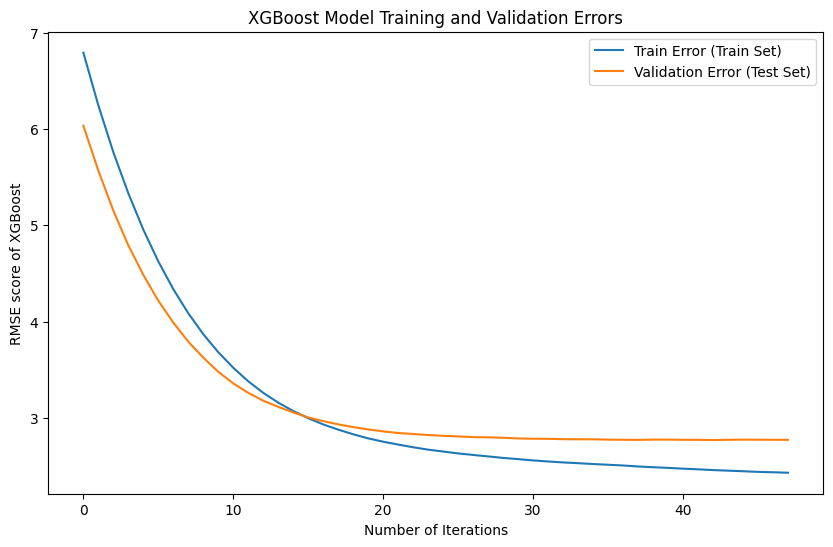

In [62]:
# acquire the values of train and validation errors
results = reg.evals_result()
train_errors = results['validation_0']['rmse']
validation_errors = results['validation_1']['rmse']

# plot the validation and training errors
plt.figure(figsize=(10, 6))
plt.plot(train_errors, label='Train Error (Train Set)')
plt.plot(validation_errors, label='Validation Error (Test Set)')
plt.xlabel('Number of Iterations')
plt.ylabel('RMSE score of XGBoost')
plt.title('XGBoost Model Training and Validation Errors')
plt.legend()
plt.show()

##### Make predictions on the test set

In [63]:
y_pred_xgboost = reg.predict(X_test)

In [64]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate the MAE of XGBoost model
mae_xgboost = mean_absolute_error(y_test, y_pred_xgboost)
print("Mae is: ",mae_xgboost)

# Calculate RMSE score of XGBoost model
rmse_xgboost = mean_squared_error(y_test, y_pred_xgboost, squared=False)
print("RMSE score:", rmse_xgboost)

Mae is:  1.7136417027884827
RMSE score: 2.7675234542784173


##### Show example of how well the model learned the trainning data
Use a random path to visualize the results

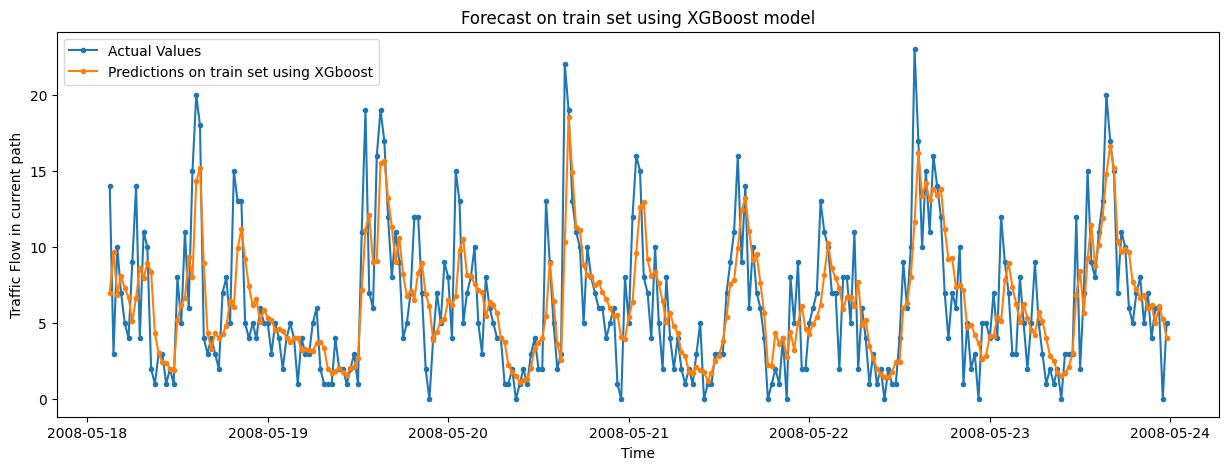

In [65]:
# predict on the trainning set
y_pred_train = reg.predict(X_train)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions at path 0 of the datase
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0]['Train Actual'],".-",label='Actual Values')
plt.plot(train_predictions[train_predictions['Path']==0]['Train Predicted'],".-",label='Predictions on train set using XGboost')
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using XGBoost model')
plt.legend()
plt.show()

As we can see, the model has learned the trend and (almost) the seasonality of the data. Despite the non-linearity of Traffic Flow, XGBoost performs quite well!

##### Show an example of actual values vs predicted on test set

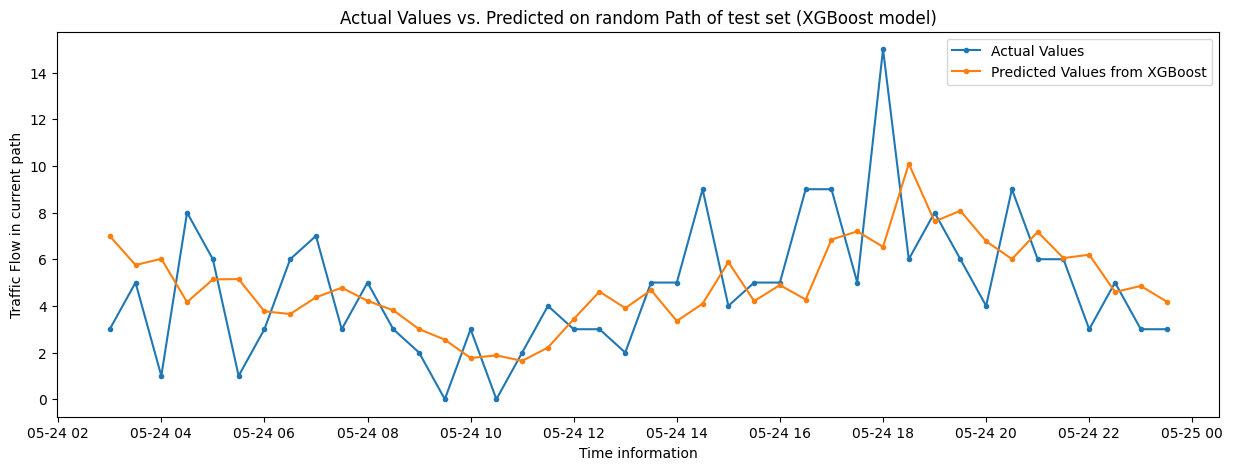

In [66]:
test_predictions = pd.DataFrame(index=pd.to_datetime(test['Time Column']))
test_predictions.insert(0,'Test Actual',y_test['Traffic Flow 1(t)'].values)
test_predictions.insert(1,'Test Predicted',y_pred_xgboost)
test_predictions.insert(2,'Path',X_test['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(test_predictions[test_predictions['Path']==0]['Test Actual'],".-",label='Actual Values')
plt.plot(test_predictions[test_predictions['Path']==0]['Test Predicted'],".-",label='Predicted Values from XGBoost')
plt.xlabel('Time information')
plt.ylabel('Traffic Flow in current path')
plt.title('Actual Values vs. Predicted on random Path of test set (XGBoost model)')
plt.legend()
plt.show()

### Train LSTM for time series forecasting
This is the second model that we will train on the same dataset. We use the optimum lookback score that we computed above.

#### Step 0: Create the train and test sets as before, then scale them
Use the same train and test sets as in the XGBoost model. In order to create more accurate predictions, we scale those two sets before giving them as input to the LSTM RNN model.

In [67]:
from sklearn.preprocessing import MinMaxScaler

In [68]:
# scale the data
scaler = MinMaxScaler()
X_tr = scaler.fit_transform(X_train)
X_te = scaler.fit_transform(X_test)

y_tr = scaler.fit_transform(y_train)
y_te = scaler.fit_transform(y_test)

In [69]:
# create 3D train set for LSTM
trainX = []
trainY = []

for i in range(len(X_tr)):
    trainX.append(X_tr[i:i+1,:])

for i in range(len(y_tr)):
    trainY.append(y_tr[i:i+1,:])

trainX, trainY = np.array(trainX), np.array(trainY)

In [70]:
# create 3D test set FOR LSTM
testX = []
testY = []

for i in range(len(X_te)):
    testX.append(X_te[i:i+1,:])

for i in range(len(y_te)):
    testY.append(y_te[i:i+1,:])

testX, testY = np.array(testX), np.array(testY)

In [71]:
# print shapes of the created tests
trainX.shape, trainY.shape, testX.shape, testY.shape

((282000, 1, 27), (282000, 1, 1), (42000, 1, 27), (42000, 1, 1))

#### Step 2: Use the LSTM model for forecasting

##### Import libraries and define the LSTM structure

In [72]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
import tensorflow as tf

In the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [132]:
# Define LSTM model
model = Sequential()
model.add(LSTM(1000, activation='relu', return_sequences=True, input_shape=(trainX.shape[1], trainX.shape[2])))
model.add(Dropout(0.2))

#model.add(LSTM(500, activation='relu', return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(250, activation='relu', return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(120, activation='relu', return_sequences=True))
#model.add(Dropout(0.2))

model.add(LSTM(60, activation='relu', return_sequences=True))
model.add(Dropout(0.2))

# Additional Dense layers
model.add(Dense(30, activation='relu'))
model.add(Dense(15, activation='relu'))
model.add(Dense(6, activation='relu'))
model.add(Dense(3, activation='relu'))

model.add(Dense(trainY.shape[1]))  # Output layer


# Add early stopping mechanism
early_stopping = EarlyStopping(patience=10, monitor='val_loss', restore_best_weights=True)

##### Compile the model

In [133]:
# compile LSTM model
model.compile(optimizer='adam', loss='mse')

##### Train the model

In [134]:
# fit model on training data
history = model.fit(trainX, trainY,
          epochs=50,
          batch_size=len(trainX)//100,
          validation_data=(testX,testY),
          verbose=1,
          callbacks=[early_stopping])

Epoch 1/50
100/100 [==============================] - 7s 33ms/step - loss: 0.0092 - val_loss: 0.0124
Epoch 2/50
100/100 [==============================] - 3s 30ms/step - loss: 0.0084 - val_loss: 0.0124
Epoch 3/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0084 - val_loss: 0.0124
Epoch 4/50
100/100 [==============================] - 3s 26ms/step - loss: 0.0084 - val_loss: 0.0124
Epoch 5/50
100/100 [==============================] - 3s 26ms/step - loss: 0.0084 - val_loss: 0.0124
Epoch 6/50
100/100 [==============================] - 3s 27ms/step - loss: 0.0075 - val_loss: 0.0079
Epoch 7/50
100/100 [==============================] - 3s 29ms/step - loss: 0.0036 - val_loss: 0.0051
Epoch 8/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0027 - val_loss: 0.0043
Epoch 9/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0024 - val_loss: 0.0038
Epoch 10/50
100/100 [==============================] - 3s 28ms/step - loss: 0.0022 - val_lo

In [135]:
# evaluate model on test data
loss_lstm = model.evaluate(testX, testY)
print("Test Loss:", loss_lstm)

1313/1313 [==============================] - 5s 4ms/step - loss: 0.0033
Test Loss: 0.0033333878964185715


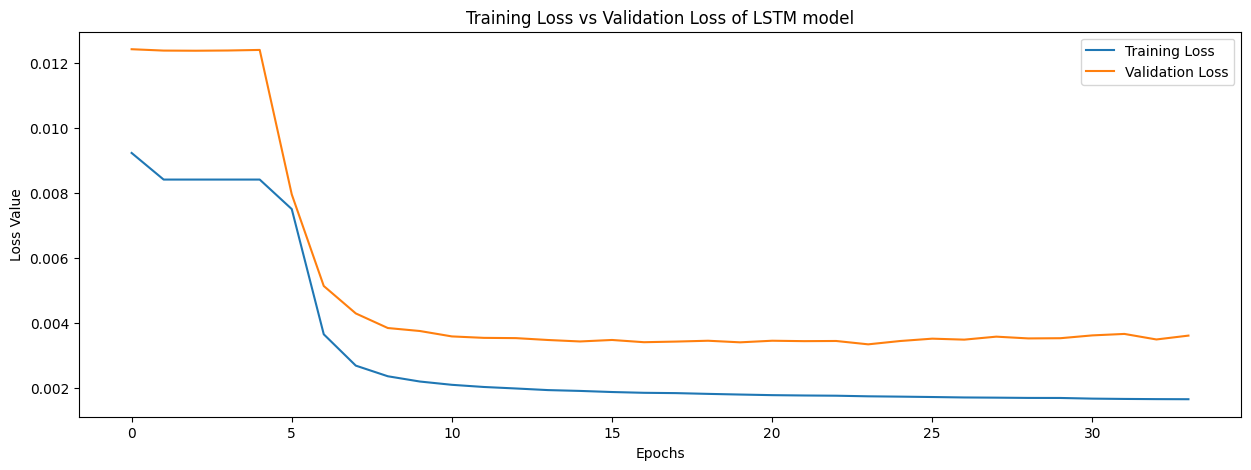

In [136]:
### PLOT TRAIN VS. VALIDATION LOSS OF LSTM MODEL ###

# extract training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# plot the losses
plt.figure(figsize=(15,5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.title('Training Loss vs Validation Loss of LSTM model')
plt.legend()

# show the plot
plt.show()

##### Make predictions on test set

In [137]:
# predict on test data
y_pred_lstm = model.predict(testX)
y_pred_lstm = scaler.inverse_transform(y_pred_lstm.reshape(-1,1))

1313/1313 [==============================] - 6s 4ms/step


#### Evaluate the LSTM model

In [138]:
# calculate the MAE score of LSTM model
mae_lstm = mean_absolute_error(scaler.inverse_transform(testY.reshape(-1,1)),y_pred_lstm)
print("Mae LSTM is: ",mae_lstm)

# Calculate the RMSE score of LSTM model
rmse_lstm = mean_squared_error(scaler.inverse_transform(testY.reshape(-1,1)), y_pred_lstm, squared=False)
print("RMSE LSTM score:", rmse_lstm)

Mae LSTM is:  1.9704807664297876
RMSE LSTM score: 2.9445096532297104


#### Show example of how well the LSTM captured/learned the train data

8813/8813 [==============================] - 42s 5ms/step


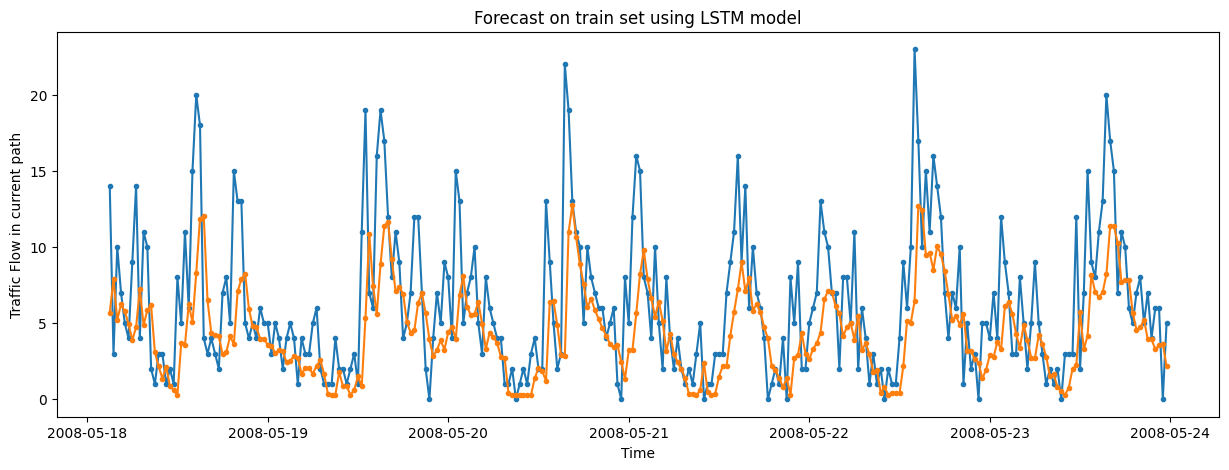

In [129]:
# predict on the trainning set
y_pred_train_LSTM = model.predict(trainX)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',scaler.inverse_transform(y_pred_train_LSTM.reshape(-1,1)))
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using LSTM model')
plt.show()

### Create Random Forest model
This is the third model that we train on the same data, in order to forecast the traffic flow prediction. This algorithm is quite the same with the XGBoost, because both of them use decision trees to make forecasts.

In [90]:
from sklearn.ensemble import RandomForestRegressor

#### Step 0: Find optimum parameters for random forest

In [92]:
# define the parameter grid for the grid search
param_grid = {
    'max_depth': [5, 7],
    'min_samples_split': [5, 10],
    'n_estimators': [50,100,150]
}

# create the Random Forest model
rf_model = RandomForestRegressor(n_jobs=-1)

# create the GridSearchCV object
grid_search = GridSearchCV(rf_model, param_grid, cv=3, scoring='neg_mean_squared_error',verbose=1)

# fit the GridSearchCV object on the training data
grid_search.fit(X_train, y_train)

# get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# print the best parameters and the best score
print("Best Parameters:", best_params)
print("Best Score:", best_score)

KeyboardInterrupt: ignored

#### Step 1: Create and train best random forest model

In [93]:
# get the best model after Grid Search
best_model = RandomForestRegressor(n_estimators=150,
                                  min_samples_split=10,
                                  max_depth=7,
                                  verbose=1,
                                  n_jobs=-1)

In [94]:
best_model.fit(X_train,y_train)

[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.9min finished


RandomForestRegressor(max_depth=7, min_samples_split=10, n_estimators=150,
                      n_jobs=-1, verbose=1)

#### Step 2: Make predictions on train set

In [95]:
# make predictions on the test set
y_pred_rf = best_model.predict(X_test)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.2s finished


[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.4s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    1.3s finished


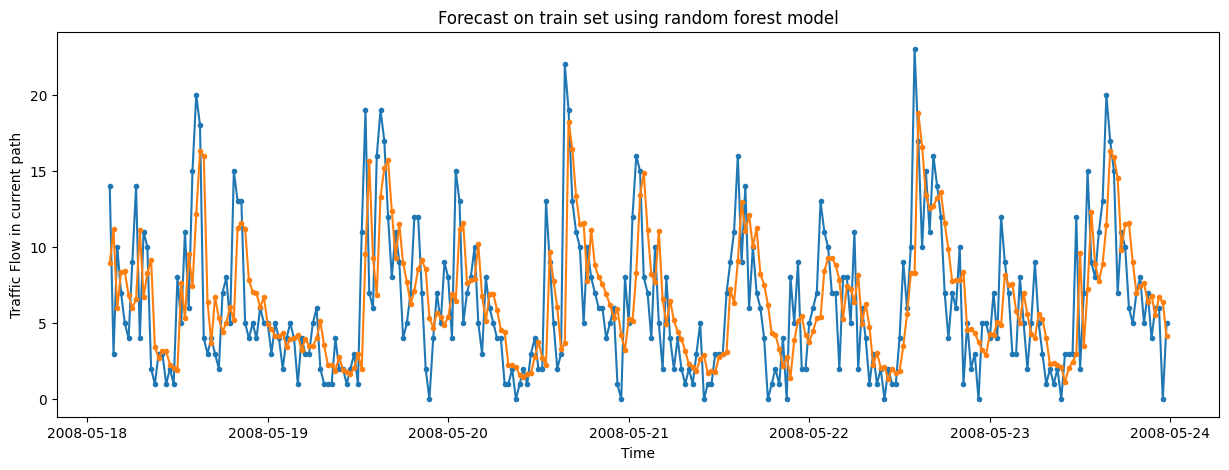

In [96]:
# predict on the trainning set using random forest
y_pred_train_rf = best_model.predict(X_train)

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train_rf)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using random forest model')
plt.show()

#### Step 3: Evalueate the random forest regressor

In [97]:
# calculate the MAE
mae_rf = mean_absolute_error(y_test, y_pred_rf)
print("MAE: ", mae_rf)

# calculate the RMSE
rmse_rf = mean_squared_error(y_test, y_pred_rf, squared=False)
print("RMSE: ", rmse_rf)

MAE:  1.74109807551408
RMSE:  2.787276350563746


### Train an Encoder-Decoder model
This is the fourth model that we are using, in order to forecast the traffic flow.

#### Step 0: Initialize and compile the Encoder-Decoder model

In [98]:
# add necessary imports
from keras import layers

In [99]:
# convert train and test set to infinite datasets for faster training
BATCH_SIZE = 1
BUFFER_SIZE = 1000

train_univariate = tf.data.Dataset.from_tensor_slices((trainX, trainY))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
val_univariate = tf.data.Dataset.from_tensor_slices((testX, testY))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [100]:
### DEFINE THE MODEL ###

# Encoder part
enco_deco = Sequential()
enco_deco.add(LSTM(100, input_shape=(1, trainX.shape[2]), return_sequences=True))
enco_deco.add(Dropout(0.2))  # Add dropout to the first LSTM layer
enco_deco.add(LSTM(units=50, return_sequences=True))
enco_deco.add(Dropout(0.2))  # Add dropout to the second LSTM layer
enco_deco.add(LSTM(units=15))

# Feature vector
enco_deco.add(layers.RepeatVector(1))

# Decoder part
enco_deco.add(LSTM(units=100, return_sequences=True))
enco_deco.add(LSTM(units=50, return_sequences=True))
enco_deco.add(TimeDistributed(layers.Dense(units=1)))

Similart to the LSTM model, we include dense layers to capture more complex non linear patterns and dropout layers to prevent overfitting.

In [101]:
enco_deco.compile(optimizer='adam', loss='mse')

#### Step 1: Train the model and make predictions

In [102]:
# train the enco-deco model
history = enco_deco.fit(train_univariate,
                        epochs=50,
                        steps_per_epoch=len(trainX)//100,
                        validation_data=val_univariate,
                        validation_steps=len(testX)//100,
                        verbose=1,
                        callbacks=[early_stopping])

Epoch 1/50
2820/2820 [==============================] - 65s 20ms/step - loss: 0.0035 - val_loss: 0.0057
Epoch 2/50
 412/2820 [===>..........................] - ETA: 27s - loss: 0.0025

KeyboardInterrupt: ignored

In [ ]:
# make predictions using Encoder-Decoder model
predicted_enco_deco = enco_deco.predict(testX)
predicted_enco_deco = scaler.inverse_transform(predicted_enco_deco.reshape(-1, 1))

#### Step 2: Evaluate the model

In [ ]:
# Calculate MAE of Encoder - Decoder model
mae_enco_deco = mean_absolute_error(y_test, predicted_enco_deco)

# Calculate RMSE Encoder - Decoder model
rmse_enco_deco = mean_squared_error(y_test, predicted_enco_deco, squared=False)

print("MAE:", mae_enco_deco)
print("RMSE:", rmse_enco_deco)

Plot train loss vs. validation loss

In [ ]:
# Get the loss and validation loss values and pllot them in the same graph
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss and validation loss
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss of Encoder-Decoder model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Forecast on train set using Encoder-Decoder model

In [ ]:
# predict on the trainning set
y_pred_train_enco_deco = enco_deco.predict(trainX)
y_pred_train_enco_deco = scaler.inverse_transform(y_pred_train_enco_deco.reshape(-1, 1))

# add information in the trainning set
train_predictions = pd.DataFrame(index=pd.to_datetime(train['Time Column']))
train_predictions.insert(0,'Train Actual',y_train['Traffic Flow 1(t)'].values)
train_predictions.insert(1,'Train Predicted',y_pred_train_enco_deco)
train_predictions.insert(2,'Path',X_train['Path'].values)

# plot an example of the train-predictions
plt.figure(figsize=(15,5))
plt.plot(train_predictions[train_predictions['Path']==0][['Train Actual','Train Predicted']],".-")
plt.xlabel('Time')
plt.ylabel('Traffic Flow in current path')
plt.title('Forecast on train set using Encoder-Decoder model')
plt.show()

### Add predictions of the four models to the same dataframe

In [103]:
# store predictions of XGBoost model to a dataframe
total_predictions['Predicted XGBoost'] = y_pred_xgboost

In [141]:
# store predictions of LSTM model to a dataframe
total_predictions['Predicted LSTM'] = y_pred_lstm

In [105]:
# add predictions of random forest
total_predictions['Predicted Random Forest'] = y_pred_rf

In [ ]:
# add predictions of encoder decoder model
total_predictions['Predicted Encoder Decoder Model'] = predicted_enco_deco

In [142]:
# print dataframe with predictions
total_predictions

,Actual,Path,Predicted XGBoost,Predicted LSTM,Predicted Random Forest
Time Column,,,,,
2008-05-24 03:00:00,3.0,0,6.994709,8.774597,7.609670
2008-05-24 03:30:00,5.0,0,5.750947,6.511318,5.404145
2008-05-24 04:00:00,1.0,0,6.018699,7.148524,5.966174
2008-05-24 04:30:00,8.0,0,4.161683,5.013802,4.408676
2008-05-24 05:00:00,6.0,0,5.133581,6.844237,5.447925
...,...,...,...,...,...
2008-05-24 21:30:00,3.0,999,4.223202,6.049234,4.193277
2008-05-24 22:00:00,7.0,999,4.154117,4.184390,4.315564
2008-05-24 22:30:00,6.0,999,4.272381,5.253001,5.279163


### Add in the same dataframe the scores of each model, in order to compare them

In [143]:
# create dataframe with scores
scores = pd.DataFrame(columns=['Model','RMSE Score','MAE Score'])

# define rows for dataframe
new_row = {'Model': 'XGBoost', 'RMSE Score': rmse_xgboost, 'MAE Score': mae_xgboost}
new_row1 = {'Model': 'LSTM', 'RMSE Score': rmse_lstm, 'MAE Score': mae_lstm}
new_row2 = {'Model': 'Random Forest', 'RMSE Score': rmse_rf, 'MAE Score': mae_rf}
new_row3 = {'Model': 'Encoder Decoder', 'RMSE Score': rmse_enco_deco, 'MAE Score': mae_enco_deco}

# add rows to dataframe
scores = scores.append(new_row, ignore_index=True)
scores = scores.append(new_row1, ignore_index=True)
scores = scores.append(new_row2, ignore_index=True)
scores = scores.append(new_row3, ignore_index=True)

NameError: ignored

In [115]:
# print dataframe with scores
scores

,Model,RMSE Score,MAE Score
0,XGBoost,2.767523,1.713642
1,LSTM,2.912484,1.849435
2,Random Forest,2.787276,1.741098


### Plot examples of actual vs Predicted for each of the models
In this part, we select a random path of the dataset and compare (for each model) the actual Traffic Flow values vs. the predicted ones

[]

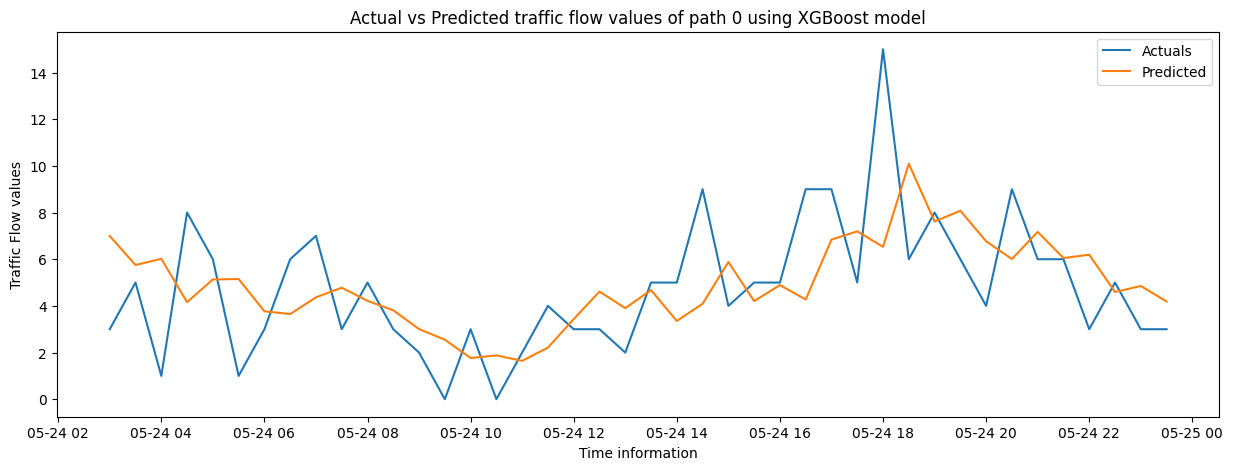

In [111]:
# plot results from XGBoost
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted XGBoost'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 0 using XGBoost model')
plt.legend()
plt.plot()

[]

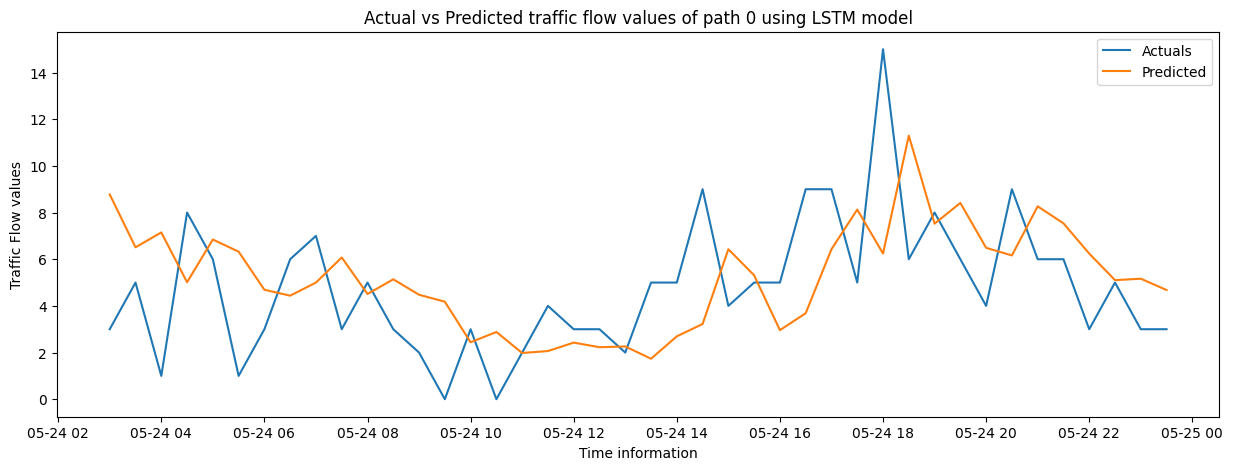

In [144]:
# plot results from LSTM
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted LSTM'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 0 using LSTM model')
plt.legend()
plt.plot()

[]

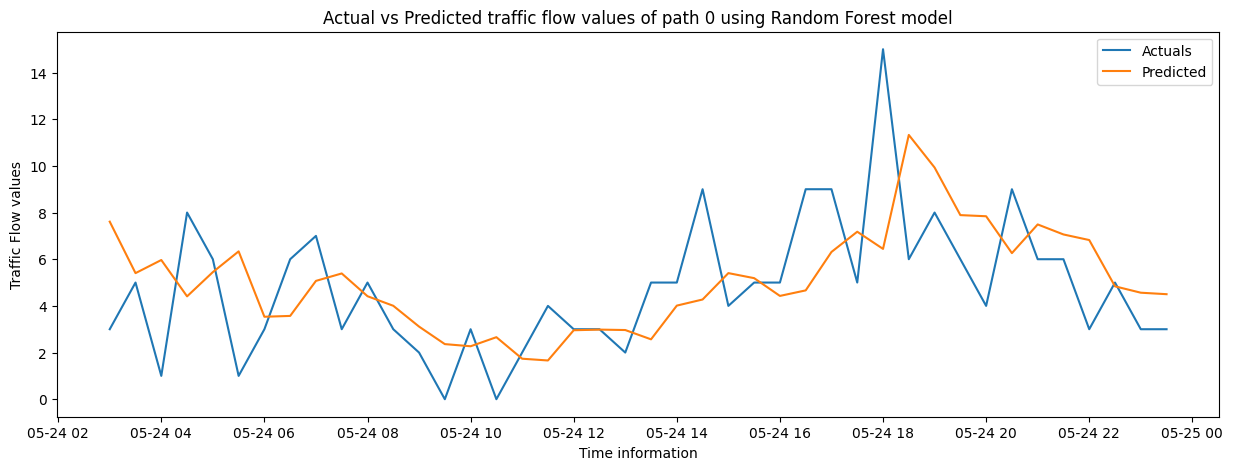

In [113]:
# plot results from Random Forest
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted Random Forest'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 0 using Random Forest model')
plt.legend()
plt.plot()

In [ ]:
# plot results from Encoder Decoder
plt.figure(figsize=(15,5))
plt.plot(total_predictions[total_predictions['Path']==0]['Actual'],label='Actuals')
plt.plot(total_predictions[total_predictions['Path']==0]['Predicted Encoder Decoder Model'],label='Predicted')
plt.xlabel("Time information")
plt.ylabel('Traffic Flow values')
plt.title('Actual vs Predicted traffic flow values of path 0 using Encoder-Decoder model model')
plt.legend()
plt.plot()